# Higgs Boson Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold, 
                                     train_test_split)
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Data
The [dataset is obtained from UCI](https://archive.ics.uci.edu/ml/datasets/HIGGS) and contains 21 features measured by detectors in an accelerator and the last 7 are generated based on the first 21 and consists of 11000000 rows. The `label` colum contains label which is 1 for the boson and 0 for background noise.

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-05-19 18:25:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  21.9MB/s    in 2m 3s   

2021-05-19 18:27:46 (21.9 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [3]:
!gzip -d HIGGS.csv.gz

The columns are: label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb.

In [4]:
columns = ["label","lepton pT", "lepton eta", "lepton phi", "missing energy magnitude", "missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]
df = pd.read_csv("HIGGS.csv", names=columns)
df.head()

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [5]:
df.shape

(11000000, 29)

Sample only 3% of the whole data and use only generated feature. The full data set and all features will be explored using Apache Spark.

In [6]:
synthetic_df = df.iloc[:, 22:].copy()
synthetic_df["label"] = df["label"]
sample_df = synthetic_df.sample(frac=0.03, random_state=1)

## Exploratory Data Analysis

In [7]:
sample_df.describe().T

,count,mean,std,min,25%,50%,75%,max
m_jj,330000.0,1.032526,0.676221,0.075070,0.789949,0.894591,1.023924,23.905035
m_jjj,330000.0,1.023821,0.380956,0.298855,0.845418,0.950721,1.083120,12.174695
m_lv,330000.0,1.050750,0.165726,0.091056,0.985755,0.989779,1.020394,5.520823
m_jlv,330000.0,1.010015,0.397183,0.157473,0.767731,0.917305,1.143385,8.266503
m_bb,330000.0,0.974177,0.525668,0.056099,0.674886,0.874249,1.139110,9.784142
m_wbb,330000.0,1.032752,0.364964,0.337903,0.819622,0.947605,1.139915,8.096107
m_wwbb,330000.0,0.959685,0.312603,0.370081,0.770463,0.872114,1.058541,5.726346
label,330000.0,0.528982,0.499160,0.000000,0.000000,1.000000,1.000000,1.000000


The sampled data set does not contain any missing values.

In [8]:
sample_df.isnull().sum()

m_jj      0
m_jjj     0
m_lv      0
m_jlv     0
m_bb      0
m_wbb     0
m_wwbb    0
label     0
dtype: int64

In [ ]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330000 entries, 5620115 to 5213957
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   m_jj    330000 non-null  float64
 1   m_jjj   330000 non-null  float64
 2   m_lv    330000 non-null  float64
 3   m_jlv   330000 non-null  float64
 4   m_bb    330000 non-null  float64
 5   m_wbb   330000 non-null  float64
 6   m_wwbb  330000 non-null  float64
 7   label   330000 non-null  float64
dtypes: float64(8)
memory usage: 22.7 MB


The sampled data set contains comparable numbers of both labels.

In [ ]:
sample_df["label"].value_counts()

1.0    174564
0.0    155436
Name: label, dtype: int64

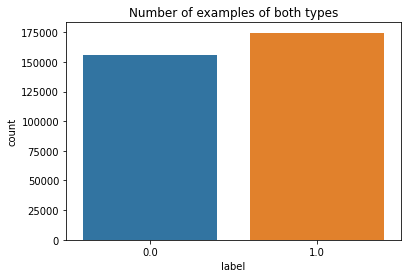

In [ ]:
cntplt = sns.countplot(x="label", data=sample_df)
cntplt.set_title("Number of examples of both types")
plt.show()

Some generated features are correlated as can be seen from pair scatter plots and correlation heat map below. Namely the Pearson correlation coefficient for `m_jjj` and `m_jj` is 0.8 and `m_wbb` and `m_wwbb` is 0.89.

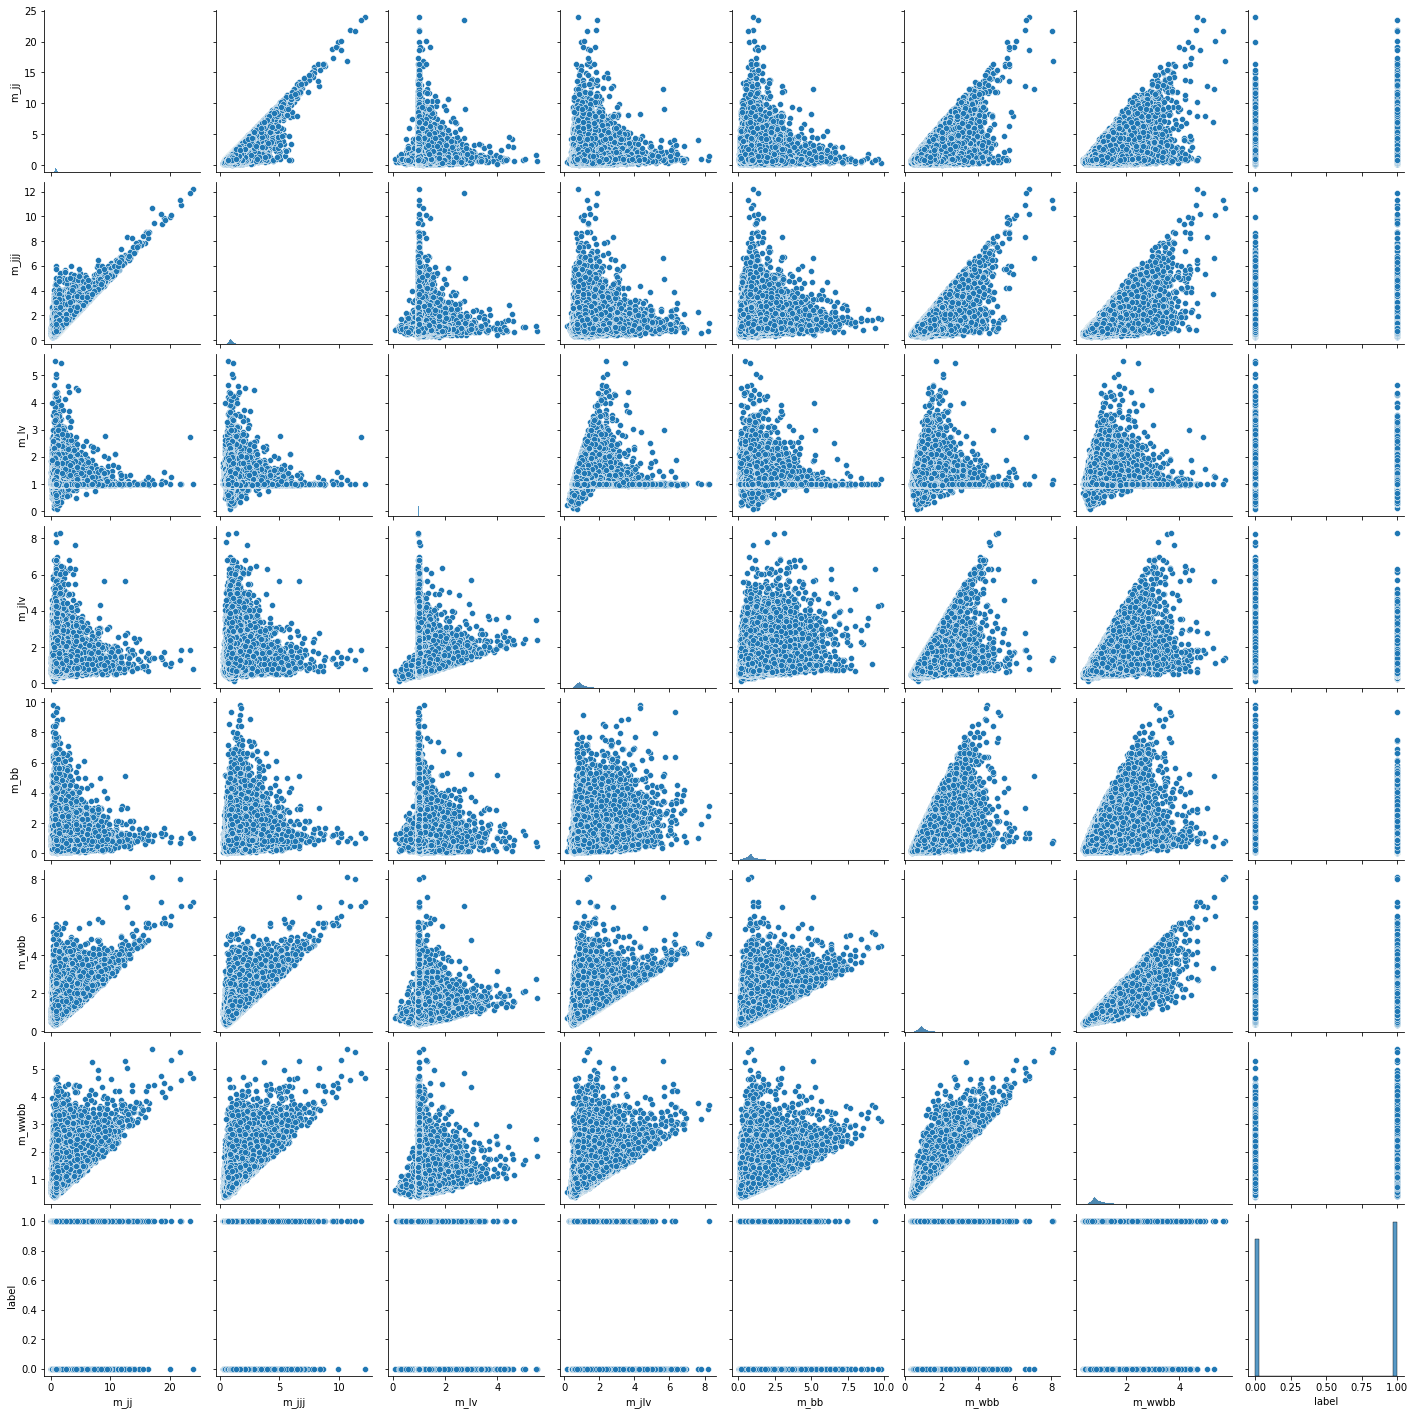

In [ ]:
sns.pairplot(data=sample_df)
plt.show()

In [ ]:
correlation = sample_df.corr()

In [7]:
!curl -O https://raw.githubusercontent.com/javaeeeee/MachineLearningNotebooks/main/utils.ipynb
%run utils.ipynb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6668  100  6668    0     0  26887      0 --:--:-- --:--:-- --:--:-- 26887


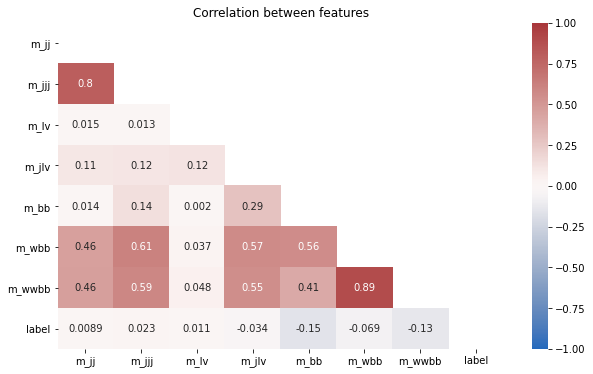

In [ ]:
plot_correlation_between_features(correlation, 10, 6)

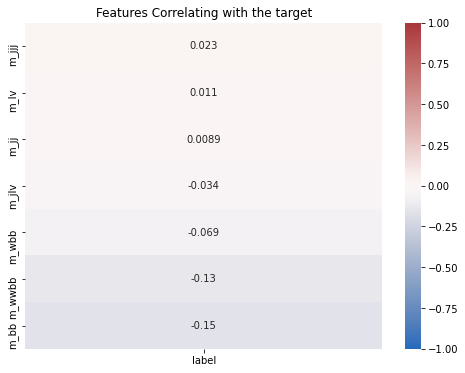

In [ ]:
plot_correlation_with_target(correlation, 8, 6, "label")

In [9]:
X = sample_df.iloc[:, :7]
y = sample_df.iloc[:, -1:]
X_train, X_test, y_train, y_test = (train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     random_state=1))

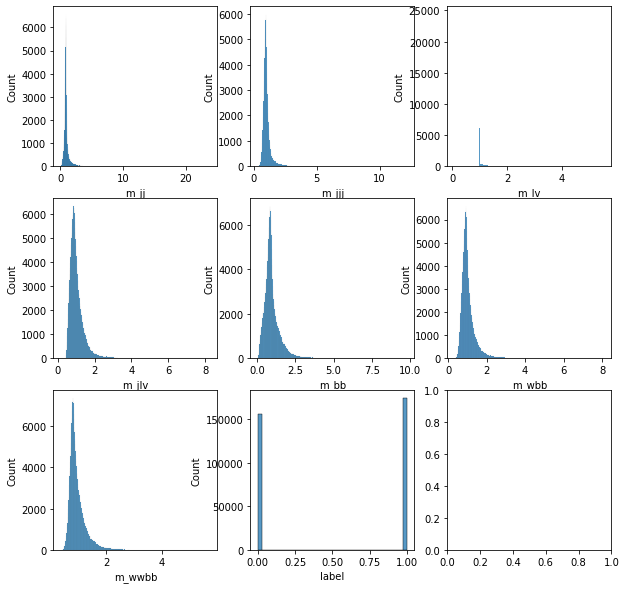

In [ ]:
plot_distributions(sample_df, 3, 3, 7, 10, 10)

Let's try [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) (RFE) with RidgeRegression

In [ ]:
# Remove correlated features
correlated_feauture_columns = ["m_wwbb", "m_jjj"]
X_train_clean = X_train.drop(columns=correlated_feauture_columns)
X_test_clean = X_test.drop(columns=correlated_feauture_columns)

In [ ]:
# Scale features
columns = X_train_clean.columns
scaler = MinMaxScaler() 
X_train_clean = pd.DataFrame(scaler.fit_transform(X_train_clean), columns  = columns)
X_test_clean = pd.DataFrame(scaler.transform(X_test_clean), columns  = columns)

In [ ]:
estimator = LogisticRegression(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
selector = RFECV(estimator=estimator, min_features_to_select=3)
selector = selector.fit(X_train_clean, y_train.values.ravel())
selector.n_features_

4

In [ ]:
columns_selected = X_train_clean.columns[selector.support_]
columns_selected

Index(['m_jj', 'm_lv', 'm_bb', 'm_wbb'], dtype='object')

In [ ]:
selector.ranking_

array([1, 1, 2, 1, 1])

In [ ]:
X_train_new = X_train_clean[columns_selected]
X_test_new = X_test_clean[columns_selected]

In [ ]:
model = LogisticRegression(random_state=1)
model.fit(X_train_new, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = model.predict(X_test_new)
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
accuracy

0.6055

In [ ]:
# Confusion Matrix
cmatrix = confusion_matrix(y_true=y_test, y_pred=preds)
cmatrix

array([[10621, 20580],
       [ 5457, 29342]])

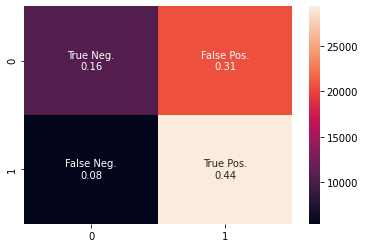

In [ ]:
plot_confusion_matrix(cmatrix)

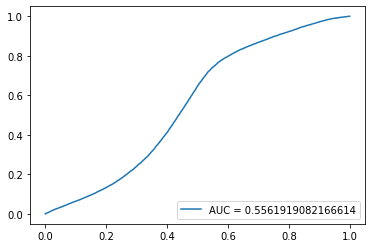

In [ ]:
plot_roc_curve(X_test_new, y_test, model)

In [ ]:
print(classification_report(y_true=y_test, y_pred=preds))

              precision    recall  f1-score   support

         0.0       0.66      0.34      0.45     31201
         1.0       0.59      0.84      0.69     34799

    accuracy                           0.61     66000
   macro avg       0.62      0.59      0.57     66000
weighted avg       0.62      0.61      0.58     66000



ElasticNet regularization with Ridge Regression

In [ ]:
# Scale all generated features
columns = X_train.columns
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [ ]:
estimator = LogisticRegression(random_state=1, max_iter=int(1e4))
param_grid = {
  'C' : np.logspace(-5,2,11),
  "penalty" : ['elasticnet'],
  'l1_ratio' : np.linspace(1e-2,1,11),
  "solver" : ['saga']
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
gs.fit(X_train_scaled, y_train.values.ravel())
regularized_model = gs.best_estimator_
y_pred = regularized_model.predict(X_test_scaled)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.6250606060606061

In [ ]:
gs.best_params_

{'C': 0.1584893192461111,
 'l1_ratio': 1.0,
 'penalty': 'elasticnet',
 'solver': 'saga'}

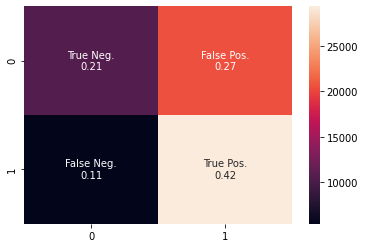

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

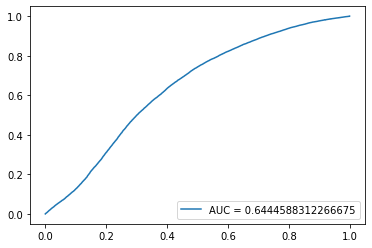

In [ ]:
plot_roc_curve(X_test_scaled, y_test, regularized_model)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.43      0.52     31201
         1.0       0.61      0.80      0.69     34799

    accuracy                           0.63     66000
   macro avg       0.63      0.62      0.61     66000
weighted avg       0.63      0.63      0.61     66000



Random Forest Classification

In [ ]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
rf_preds = rf_model.predict(X_test)
accuracy_score(y_true=y_test, y_pred=rf_preds)

0.7019545454545455

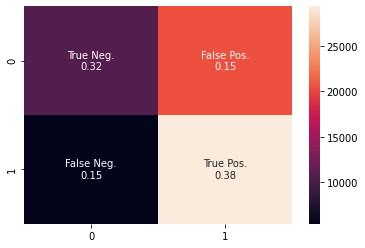

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=rf_preds))

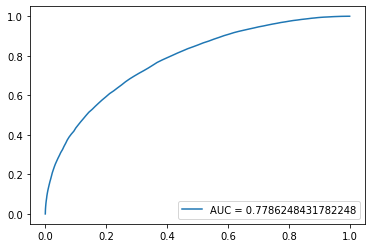

In [ ]:
plot_roc_curve(X_test, y_test, rf_model)

In [ ]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68     31201
         1.0       0.71      0.72      0.72     34799

    accuracy                           0.70     66000
   macro avg       0.70      0.70      0.70     66000
weighted avg       0.70      0.70      0.70     66000



In [10]:
n_estimators = [int(val) for val in np.linspace(start=100, stop=500, num=6)]
max_features = ["sqrt", "log2", None]

In [ ]:
rfc = RandomForestClassifier(random_state=1)
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
rs = GridSearchCV(estimator=rfc, 
                  param_grid=random_grid, 
                  cv=cv)
rs.fit(X_train, y_train.values.ravel())
rfc_optimizer = rs.best_estimator_
rs.best_params_

In [ ]:
optimized_preds = rfc_optimizer.predict(X_test)
accuracy_score(y_true=y_test, y_pred=optimized_preds)

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=optimized_preds))

In [ ]:
plot_roc_curve(X_test, y_test, rfc_optimizer)

In [ ]:
print(classification_report(y_true=y_test, y_pred=optimized_preds))

In [ ]:
plot_feature_importance(rfc_optimizer.feature_importances_, 8, 6)